# Crypto currency price history

## 1. Read Data

In [30]:
import os, glob
from pathlib import Path
import pandas as pd
import pickle as pkl

In [31]:
if os.path.isfile("../data/interim/crypto.pkl"): # if data is already read
    data = pkl.load(open('../data/interim/crypto.pkl', 'rb'))
else:
    REL_PATH = "../data/raw/cryptocurrencypricehistory/*.csv" # working with .csv files
    # two kind of files: datasets and price (classification based on its inner data and structure)

    data = {i: list() for i in ['datasets', 'price']} # init data structure
    
    for file in glob.glob(REL_PATH):
        df = pd.read_csv(file)
        filename = Path(file).stem
        
        df["Crypto"] = pd.Series([filename] * df.shape[0], dtype=pd.StringDtype()) # to identify each record
        data['price'].append(df) if filename.split('_')[-1] == 'price' else data['datasets'].append(df)
                
        pkl.dump(data, open('../data/interim/crypto.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL) # save read data


In [22]:
data['price'][0].info() # get first feedback from the data structure
data['price'][0].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        45 non-null     object 
 1   Open        45 non-null     float64
 2   High        45 non-null     float64
 3   Low         45 non-null     float64
 4   Close       45 non-null     float64
 5   Volume      45 non-null     object 
 6   Market Cap  45 non-null     object 
 7   Crypto      45 non-null     string 
dtypes: float64(4), object(3), string(1)
memory usage: 2.9+ KB


,Date,Open,High,Low,Close,Volume,Market Cap,Crypto
0,"Sep 05, 2017",514.90,550.95,458.78,541.71,"338,978,000","8,527,100,000",bitcoin_cash_price
1,"Sep 04, 2017",608.26,608.26,500.75,517.24,"328,957,000","10,072,200,000",bitcoin_cash_price
2,"Sep 03, 2017",578.27,617.41,563.59,607.43,"344,862,000","9,574,520,000",bitcoin_cash_price
3,"Sep 02, 2017",621.96,642.05,560.58,575.90,"350,478,000","10,297,000,000",bitcoin_cash_price
4,"Sep 01, 2017",588.40,645.52,586.73,622.17,"393,839,000","9,740,460,000",bitcoin_cash_price


## 2. Clean Data

In [23]:
pd.options.mode.chained_assignment = None  # avoid default='warn'

def parse_num(x):
    return x.replace(',','') if type(x) is str else x

def clean(df):
    df.Date = pd.to_datetime(df.Date, format = "%b %d, %Y")
    df = df.loc[(df["Market Cap"] != '-') & (df["Volume"] != '-')]
    df.Volume = df.Volume.apply(lambda x: parse_num(x)).astype('int64')
    df["Market Cap"] = df["Market Cap"].apply(lambda x: parse_num(x)).astype('int64')
    return df

data['price'] = list(map(clean, data['price']))
data['price'][0].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        35 non-null     datetime64[ns]
 1   Open        35 non-null     float64       
 2   High        35 non-null     float64       
 3   Low         35 non-null     float64       
 4   Close       35 non-null     float64       
 5   Volume      35 non-null     int64         
 6   Market Cap  35 non-null     int64         
 7   Crypto      35 non-null     string        
dtypes: datetime64[ns](1), float64(4), int64(2), string(1)
memory usage: 2.5 KB


### 2.2 Generate Profile Report
As we cleaned the data just by observing the dataframes format, then we want to get deeper running a complete report
Better way to get more information

In [5]:
from pandas_profiling import ProfileReport

REP_PATH = "../reports/"

def report(df, output, sub_dir=""):
    profile = ProfileReport(df, title="Pandas Profiling Report {}".format(output), explorative=False, progress_bar=False)
    profile.to_widgets()
    
    directory = os.path.join(REP_PATH + sub_dir, output)
    os.makedirs(directory, exist_ok=True)
    profile.to_file(os.path.join(directory, output + ".html"))
    profile.to_file(os.path.join(directory, output + ".json"))

[report(df, df['Crypto'][0], "price") for df in data['price']]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [5]:
dff = pd.concat(data['price'], axis=0) # as the tables have the same format and relates to the same info

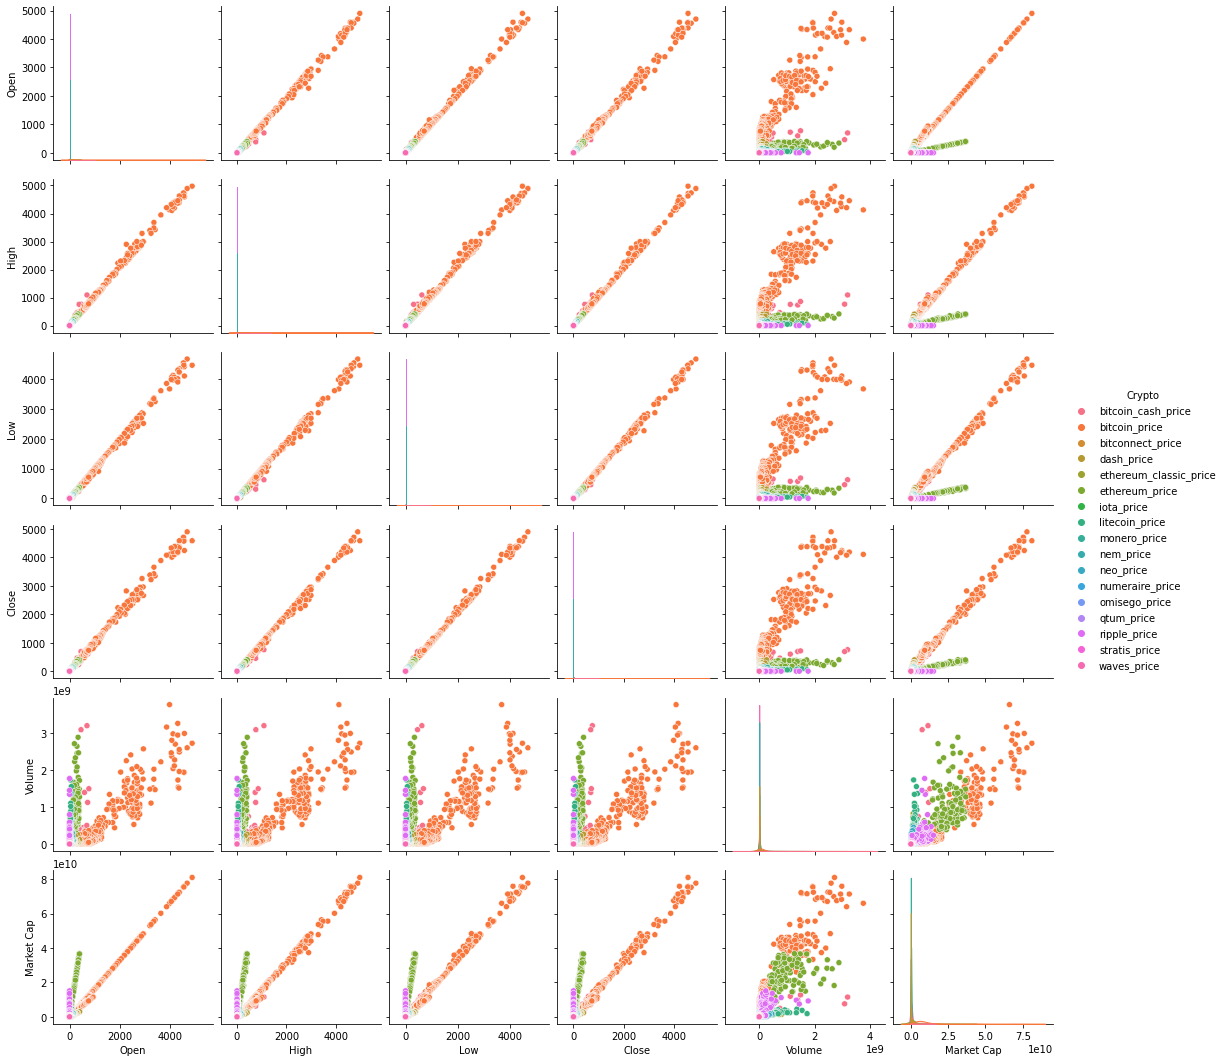

In [7]:
import seaborn as sns
sns.pairplot(dff, hue="Crypto")

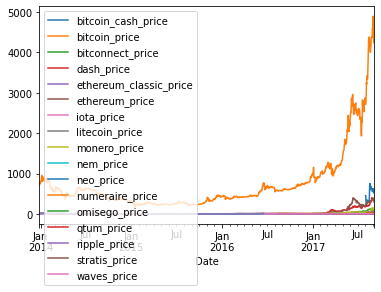

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for key, grp in dff.groupby(['Crypto']):
    ax = grp.plot(ax=ax, kind='line', x='Date', y='Close', label=key)

In [32]:
df_bitcoin = data['datasets'][0]
df_bitcoin.info()
df_bitcoin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 25 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 1584 non-null   object 
 1   btc_market_price                                     1584 non-null   float64
 2   btc_total_bitcoins                                   1584 non-null   float64
 3   btc_market_cap                                       1584 non-null   float64
 4   btc_trade_volume                                     1106 non-null   float64
 5   btc_blocks_size                                      1584 non-null   float64
 6   btc_avg_block_size                                   1584 non-null   float64
 7   btc_n_orphaned_blocks                                1584 non-null   float64
 8   btc_n_transactions_per_block                         1584 non-null  

,Date,btc_market_price,btc_total_bitcoins,btc_market_cap,btc_trade_volume,btc_blocks_size,btc_avg_block_size,btc_n_orphaned_blocks,btc_n_transactions_per_block,btc_median_confirmation_time,...,btc_cost_per_transaction,btc_n_unique_addresses,btc_n_transactions,btc_n_transactions_total,btc_n_transactions_excluding_popular,btc_n_transactions_excluding_chains_longer_than_100,btc_output_volume,btc_estimated_transaction_volume,btc_estimated_transaction_volume_usd,Crypto
0,2009-01-03 00:00:00,0.0,50.0,0.0,0.0,0.0,0.000285,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,50.0,0.0,0.0,bitcoin_dataset
1,2009-01-05 00:00:00,0.0,50.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,bitcoin_dataset
2,2009-01-07 00:00:00,0.0,50.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,bitcoin_dataset
3,2009-01-09 00:00:00,0.0,750.0,0.0,0.0,0.0,0.000215,0.0,1.0,0.0,...,0.0,14.0,14.0,15.0,14.0,14.0,700.0,0.0,0.0,bitcoin_dataset
4,2009-01-11 00:00:00,0.0,7600.0,0.0,0.0,0.0,0.000215,0.0,1.0,0.0,...,0.0,106.0,106.0,152.0,106.0,106.0,5300.0,0.0,0.0,bitcoin_dataset


In [33]:
df_bitcoin.Date = pd.to_datetime(df_bitcoin.Date, format = "%Y-%m-%d %H:%M:%S")
df_ethereum = df_ethereum.rename(columns={'btc_market_price': 'Price'})
df_bitcoin.isna().sum()
df_bitcoin = df_bitcoin.fillna(0)

data['datasets'][0] = df_bitcoin
data['datasets'][0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1584 entries, 0 to 1583
Data columns (total 25 columns):
 #   Column                                               Non-Null Count  Dtype         
---  ------                                               --------------  -----         
 0   Date                                                 1584 non-null   datetime64[ns]
 1   btc_market_price                                     1584 non-null   float64       
 2   btc_total_bitcoins                                   1584 non-null   float64       
 3   btc_market_cap                                       1584 non-null   float64       
 4   btc_trade_volume                                     1584 non-null   float64       
 5   btc_blocks_size                                      1584 non-null   float64       
 6   btc_avg_block_size                                   1584 non-null   float64       
 7   btc_n_orphaned_blocks                                1584 non-null   float64       
 8 

In [34]:
df_ethereum = data['datasets'][1]
df_ethereum.info()
df_ethereum.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date(UTC)          769 non-null    object 
 1   UnixTimeStamp      769 non-null    int64  
 2   eth_etherprice     769 non-null    float64
 3   eth_tx             769 non-null    int64  
 4   eth_address        769 non-null    int64  
 5   eth_supply         769 non-null    float64
 6   eth_marketcap      769 non-null    float64
 7   eth_hashrate       769 non-null    float64
 8   eth_difficulty     769 non-null    float64
 9   eth_blocks         769 non-null    int64  
 10  eth_uncles         769 non-null    int64  
 11  eth_blocksize      769 non-null    int64  
 12  eth_blocktime      769 non-null    float64
 13  eth_gasprice       769 non-null    int64  
 14  eth_gaslimit       769 non-null    int64  
 15  eth_gasused        769 non-null    int64  
 16  eth_ethersupply    769 non

,Date(UTC),UnixTimeStamp,eth_etherprice,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_uncles,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,eth_ethersupply,eth_chaindatasize,eth_ens_register,Crypto
0,7/30/2015,1438214400,0.0,8893,9205,7.204931e+07,0.0,23.7569,0.121,6912,1299,644,4.46,0,0,0,39316.09375,NaN,NaN,ethereum_dataset
1,7/31/2015,1438300800,0.0,0,9361,7.208550e+07,0.0,48.1584,0.603,6863,511,582,12.58,0,0,0,36191.71875,NaN,NaN,ethereum_dataset
2,8/1/2015,1438387200,0.0,0,9476,7.211320e+07,0.0,55.2709,0.887,5293,334,575,16.34,0,0,0,27705.93750,NaN,NaN,ethereum_dataset
3,8/2/2015,1438473600,0.0,0,9563,7.214143e+07,0.0,64.1779,1.020,5358,394,581,16.12,0,0,0,28223.43750,NaN,NaN,ethereum_dataset
4,8/3/2015,1438560000,0.0,0,9639,7.216940e+07,0.0,69.8559,1.126,5280,443,587,16.37,0,0,0,27976.71875,NaN,NaN,ethereum_dataset


In [35]:
df_ethereum = df_ethereum.rename(columns={'Date(UTC)': 'Date'})
df_ethereum = df_ethereum.rename(columns={'eth_etherprice': 'Price'})
df_ethereum.Date = pd.to_datetime(df_ethereum.Date, format = "%m/%d/%Y")
df_ethereum.isna().sum()
df_ethereum = df_ethereum.drop('eth_chaindatasize', 1)
df_ethereum = df_ethereum.fillna(0)

data['datasets'][1] = df_ethereum
data['datasets'][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              769 non-null    datetime64[ns]
 1   UnixTimeStamp     769 non-null    int64         
 2   Price             769 non-null    float64       
 3   eth_tx            769 non-null    int64         
 4   eth_address       769 non-null    int64         
 5   eth_supply        769 non-null    float64       
 6   eth_marketcap     769 non-null    float64       
 7   eth_hashrate      769 non-null    float64       
 8   eth_difficulty    769 non-null    float64       
 9   eth_blocks        769 non-null    int64         
 10  eth_uncles        769 non-null    int64         
 11  eth_blocksize     769 non-null    int64         
 12  eth_blocktime     769 non-null    float64       
 13  eth_gasprice      769 non-null    int64         
 14  eth_gaslimit      769 non-

In [36]:
dff = pd.concat(data['datasets'], axis=0)

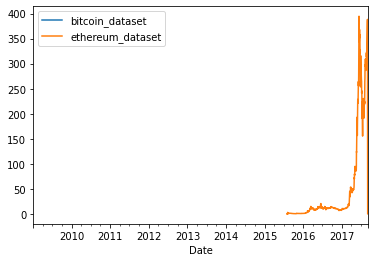

In [37]:
fig, ax = plt.subplots()
for key, grp in dff.groupby(['Crypto']):
    ax = grp.plot(ax=ax, kind='line', x='Date', y='Price', label=key)